In [1]:
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

from models.vae import create_VAE

2023-07-27 03:29:06.959362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with h5py.File("data/processed_data_128_20230726.h5", "r") as f:
    imgs_train, labels_train = np.array(f["X_train"]), np.array(f["y_train"])
    imgs_test, labels_test = np.array(f["X_test"]), np.array(f["y_test"])

print("Dimensión de imágenes:", imgs_train.shape)
print("Dimensión de labels:", labels_train.shape)

Dimensión de imágenes: (2937, 128, 128, 1)
Dimensión de labels: (2937, 4)


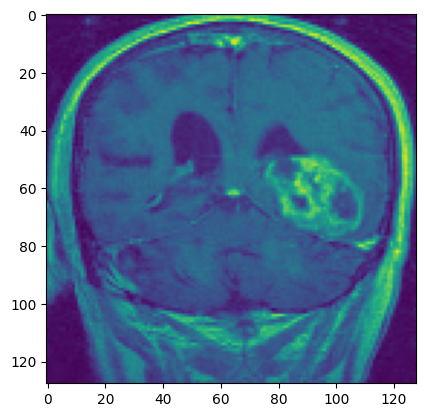

In [3]:
plt.imshow(imgs_train[0])

In [4]:
# Ill be using the JDM-19 as the pretrained model in both versions 512 and 256
input_img_shape = (128, 128, 1)

JDM19_256 = create_VAE(input_img_shape, latent_dim = 256,  n_blocks=19)
JDM19_256(imgs_train[0:1]) # For building the model (necessary for loading weights)
JDM19_256.load_weights("models/JDM_weights/JDM-19_256_best.h5")

JDM19_512 = create_VAE(input_img_shape, latent_dim = 512,  n_blocks=19)
JDM19_512(imgs_train[0:1]) # For building the model (necessary for loading weights)
JDM19_512.load_weights("models/JDM_weights/JDM-19_512_best.h5")

2023-07-27 03:29:08.316692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 03:29:08.319441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 03:29:08.319538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
n_cat = labels_train.shape[1]
cvae = create_VAE(input_img_shape, latent_dim = 256,  n_blocks=19, 
                  n_cat=labels_train.shape[1],
                  conditional=True)

# Transferencia de pesos

In [6]:
for weights_pretrained, weights_conditional in zip(JDM19_256.trainable_weights, cvae.trainable_weights):
    if weights_conditional.shape == weights_pretrained.shape:
        weights_conditional.assign(weights_pretrained)
    else:
        # note que es la misma arquitectura, solo hay un concatenate con los labels en
        # un par de capas y hacemos transferencia simplemente de las neuronas que tienen..
        weights_conditional[:-n_cat].assign(weights_pretrained)

# Congelamiento de capas

En particular, vamos a congelar las capas convolucionales del encoder ya que estas no se procesaban el label. Posteriormente las vamos a descongelar par aun poco de fine tuning algunas épocas...

In [7]:
freezed_layers = []

In [8]:
for layer in cvae.encoder.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False
        freezed_layers.append(layer)

# Entrenamiento



In [9]:
cvae.compile(optimizer=tf.keras.optimizers.Adam(1e-5)) # optimizador con baja learning rate

history = cvae.fit([imgs_train, labels_train], epochs=40, batch_size=64)

Epoch 1/40


2023-07-27 03:29:17.221760: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f50f95cae20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-27 03:29:17.221784: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-27 03:29:17.224442: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-27 03:29:17.294543: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 [==============================] - 25s 254ms/step - loss: 5990.5830 - reconstruction_loss: 5959.8008 - kl_loss: 25.5718
Epoch 2/40
46/46 [==============================] - 7s 148ms/step - loss: 5980.3062 - reconstruction_loss: 5940.3589 - kl_loss: 25.5430
Epoch 3/40
46/46 [==============================] - 7s 148ms/step - loss: 5918.8983 - reconstruction_loss: 5931.9302 - kl_loss: 25.6600
Epoch 4/40
46/46 [==============================] - 7s 148ms/step - loss: 5957.4039 - reconstruction_loss: 5925.4995 - kl_loss: 25.7132
Epoch 5/40
46/46 [==============================] - 7s 149ms/step - loss: 5965.4340 - reconstruction_loss: 5920.1157 - kl_loss: 26.0628
Epoch 6/40
46/46 [==============================] - 7s 149ms/step - loss: 5900.1450 - reconstruction_loss: 5915.2217 - kl_loss: 26.0498
Epoch 7/40
46/46 [==============================] - 7s 149ms/step - loss: 5932.7666 - reconstruction_loss: 5911.8159 - kl_loss: 26.0790
Epoch 8/40
46/46 [==============================] - 7s 149

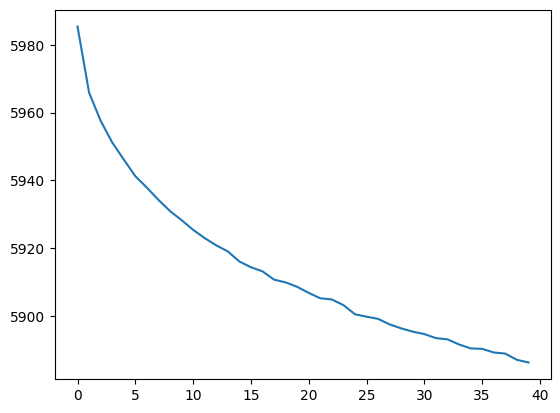

In [10]:
plt.plot(history.history["loss"])

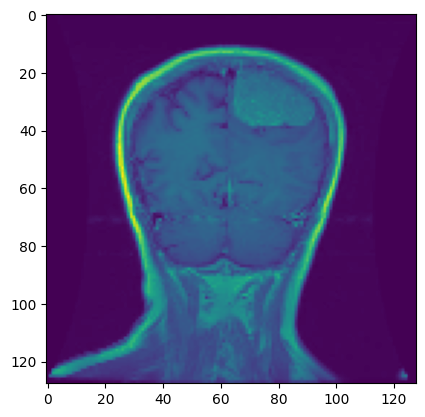

In [11]:
plt.imshow(imgs_test[0])

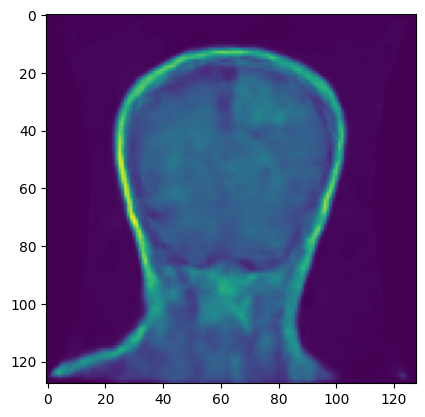

In [12]:
plt.imshow(cvae([imgs_test[0:1], labels_test[0:1]])[0])

# Fine-tuning

Descongelamos las capas y lo entrenamos algunas épocas

In [13]:
for layer in freezed_layers:
    layer.trainable = True

In [14]:
history = cvae.fit([imgs_train, labels_train], epochs=20, batch_size=64)

Epoch 1/20
46/46 [==============================] - 7s 149ms/step - loss: 5868.9231 - reconstruction_loss: 5859.6543 - kl_loss: 26.6934
Epoch 2/20
46/46 [==============================] - 7s 149ms/step - loss: 5865.9390 - reconstruction_loss: 5859.1768 - kl_loss: 26.8171
Epoch 3/20
46/46 [==============================] - 7s 151ms/step - loss: 5875.9523 - reconstruction_loss: 5858.2358 - kl_loss: 26.8465
Epoch 4/20
46/46 [==============================] - 7s 151ms/step - loss: 5921.3847 - reconstruction_loss: 5857.3198 - kl_loss: 26.8815
Epoch 5/20
46/46 [==============================] - 7s 149ms/step - loss: 5874.9382 - reconstruction_loss: 5856.5620 - kl_loss: 26.6475
Epoch 6/20
46/46 [==============================] - 7s 149ms/step - loss: 5888.7871 - reconstruction_loss: 5855.4824 - kl_loss: 26.8480
Epoch 7/20
46/46 [==============================] - 7s 149ms/step - loss: 5864.4776 - reconstruction_loss: 5855.7876 - kl_loss: 26.8914
Epoch 8/20
46/46 [==============================

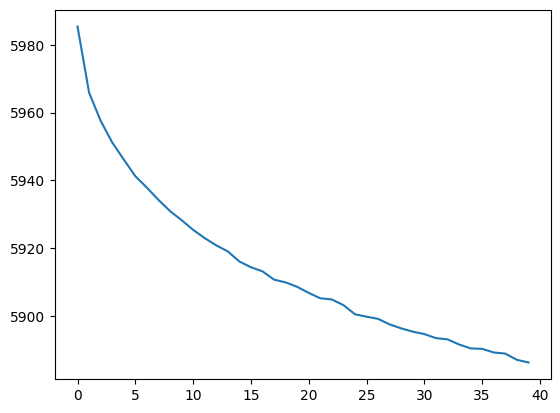

In [10]:
plt.plot(history.history["loss"])

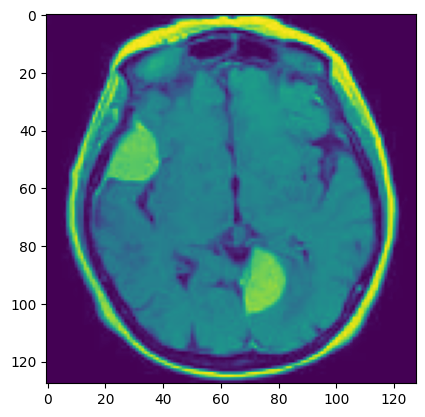

In [253]:
plt.imshow(imgs_train[10])

# Generar imagenes nuevas

In [262]:
_,_,z = cvae.encoder([imgs_train[10:11], labels_train[10:11]])

In [263]:
z += np.random.normal(0,1, size=z.shape)

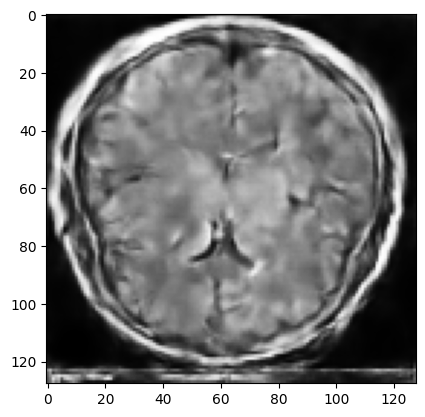

In [264]:
plt.imshow(cvae.decoder([z, labels_train[15:16]])[0], cmap="gray")

In [286]:
batches = 33
fake_data = np.split(np.zeros(shape=imgs_train.shape), batches)
for i,(chunk_imgs, chunk_labels) in enumerate(zip(np.split(imgs_train, batches), np.split(labels_train, batches))):
    _, _, z = cvae.encoder([chunk_imgs, chunk_labels])
    z+=np.random.normal(0,1, size=z.shape)
    fake_data[i] = cvae.decoder([z, chunk_labels])

In [288]:
fake_data = np.concatenate(fake_data)

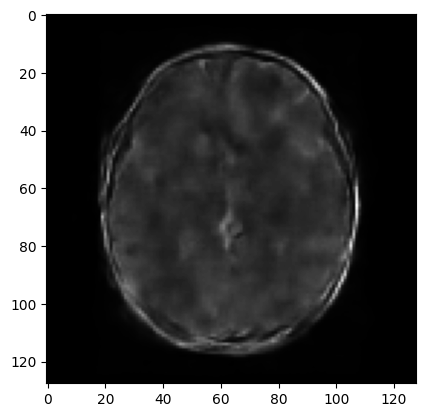

In [321]:
plt.imshow(fake_data[890], cmap="gray")

In [322]:
with h5py.File("data/fake-data-JDM19-256.h5", "w") as out: # guardar data
    out.create_dataset("X_train", fake_data.shape, dtype="float32", data=fake_data)
    out.create_dataset("y_train", labels_train.shape, dtype="u1", data=labels_train)

# TransferLearning JDM-19-512

Se realizará lo mismo que en lo anterior pero en solo código

In [329]:
n_cat = labels_train.shape[1]
cvae = create_VAE(input_img_shape, latent_dim = 512,  n_blocks=19, 
                  n_cat=labels_train.shape[1],
                  conditional=True)

for weights_pretrained, weights_conditional in zip(JDM19_512.trainable_weights, cvae.trainable_weights):
    if weights_conditional.shape == weights_pretrained.shape:
        weights_conditional.assign(weights_pretrained)
    else:
        # note que es la misma arquitectura, solo hay un concatenate con los labels en
        # un par de capas y hacemos transferencia simplemente de las neuronas que tienen..
        weights_conditional[:-n_cat].assign(weights_pretrained)

freezed_layers = []
for layer in cvae.encoder.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False
        freezed_layers.append(layer)
cvae.compile(optimizer=tf.keras.optimizers.Adam(1e-5)) # optimizador con baja learning rate
cvae.fit([imgs_train, labels_train], epochs=30, batch_size=64)

for layer in freezed_layers:
    layer.trainable = True
cvae.fit([imgs_train, labels_train], epochs=50, batch_size=64)

batches = 33
fake_data = np.split(np.zeros(shape=imgs_train.shape), batches)
for i,(chunk_imgs, chunk_labels) in enumerate(zip(np.split(imgs_train, batches), np.split(labels_train, batches))):
    _, _, z = cvae.encoder([chunk_imgs, chunk_labels])
    z+=np.random.normal(0,1, size=z.shape)
    fake_data[i] = cvae.decoder([z, chunk_labels])

fake_data = np.concatenate(fake_data)

with h5py.File("data/fake-data-JDM19-512.h5", "w") as out: # guardar data
    out.create_dataset("X_train", fake_data.shape, dtype="float32", data=fake_data)
    out.create_dataset("y_train", labels_train.shape, dtype="u1", data=labels_train)

Epoch 1/30
46/46 [==============================] - 14s 148ms/step - loss: 6045.7374 - reconstruction_loss: 5964.7954 - kl_loss: 24.1471
Epoch 2/30
46/46 [==============================] - 7s 148ms/step - loss: 5995.2197 - reconstruction_loss: 5947.0122 - kl_loss: 24.0068
Epoch 3/30
46/46 [==============================] - 7s 150ms/step - loss: 5984.9689 - reconstruction_loss: 5936.6167 - kl_loss: 24.1270
Epoch 4/30
46/46 [==============================] - 7s 150ms/step - loss: 5925.6442 - reconstruction_loss: 5929.0522 - kl_loss: 24.1255
Epoch 5/30
46/46 [==============================] - 7s 152ms/step - loss: 5915.5688 - reconstruction_loss: 5924.6372 - kl_loss: 24.1957
Epoch 6/30
46/46 [==============================] - 7s 149ms/step - loss: 5909.7836 - reconstruction_loss: 5919.8403 - kl_loss: 24.2281
Epoch 7/30
46/46 [==============================] - 7s 149ms/step - loss: 5919.7490 - reconstruction_loss: 5915.2939 - kl_loss: 24.4466
Epoch 8/30
46/46 [=============================

46/46 [==============================] - 7s 150ms/step - loss: 5921.7454 - reconstruction_loss: 5849.7100 - kl_loss: 25.1118
Epoch 31/50
46/46 [==============================] - 7s 150ms/step - loss: 5874.0648 - reconstruction_loss: 5850.2324 - kl_loss: 25.1164
Epoch 32/50
46/46 [==============================] - 7s 150ms/step - loss: 5877.6343 - reconstruction_loss: 5850.0957 - kl_loss: 25.1370
Epoch 33/50
46/46 [==============================] - 7s 148ms/step - loss: 5901.8117 - reconstruction_loss: 5847.7344 - kl_loss: 25.1509
Epoch 34/50
46/46 [==============================] - 7s 148ms/step - loss: 5909.4460 - reconstruction_loss: 5848.3125 - kl_loss: 25.2420
Epoch 35/50
46/46 [==============================] - 7s 148ms/step - loss: 5883.9555 - reconstruction_loss: 5847.6992 - kl_loss: 25.1273
Epoch 36/50
46/46 [==============================] - 7s 148ms/step - loss: 5854.6171 - reconstruction_loss: 5847.4028 - kl_loss: 25.1185
Epoch 37/50
46/46 [==============================] - 